In [1]:
from optuna.visualization import plot_optimization_history, plot_intermediate_values
from sklearn import clone


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
from code.wrapper import utils

import seaborn as sns
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import RFECV, RFE
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score

**Normalization** increases the speed of calculation and reduces the alpha value while also increasing the score
https://stats.stackexchange.com/a/189179

In [2]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
# https://stackoverflow.com/a/23835410

excel_sheet = pd.read_excel("../Data/New/unfiltered_data.xlsx", sheet_name=["full_train", "full_test",
                                                                               "ionizable_train", "ionizable_test",
                                                                               "neutral_train", "neutral_test"])


full_train: pd.DataFrame = excel_sheet["full_train"]
full_test: pd.DataFrame = excel_sheet["full_test"]

neutral_train: pd.DataFrame = excel_sheet["neutral_train"]
neutral_test: pd.DataFrame = excel_sheet["neutral_test"]

ionizable_train: pd.DataFrame = excel_sheet["ionizable_train"]
ionizable_test: pd.DataFrame = excel_sheet["ionizable_test"]

Scaler = RobustScaler()
Norm = Normalizer()
# TRAIN
X_full_train = full_train.loc[:, full_train.columns != "Log_MP_RATIO"]
y_full_train = full_train["Log_MP_RATIO"]


X_neutral_train = neutral_train.loc[:, neutral_train.columns != "Log_MP_RATIO"]
y_neutral_train = neutral_train["Log_MP_RATIO"]

X_ionizable_train = ionizable_train.loc[:, ionizable_train.columns != "Log_MP_RATIO"]
y_ionizable_train = ionizable_train["Log_MP_RATIO"]
# Scaler.fit(X_full_train)
# X_full_train = pd.DataFrame(Scaler.transform(X_full_train), columns = X_full_train.columns)
#
# Norm.fit(X_full_train)
# X_full_train = pd.DataFrame(Norm.transform(X_full_train), columns=X_full_train.columns)

# TEST
X_full_test = full_test.loc[:, full_test.columns != "Log_MP_RATIO"]
y_full_test = full_test["Log_MP_RATIO"]

X_neutral_test = neutral_test.loc[:, neutral_test.columns != "Log_MP_RATIO"]
y_neutral_test = neutral_test["Log_MP_RATIO"]

X_ionizable_test = ionizable_test.loc[:, ionizable_test.columns != "Log_MP_RATIO"]
y_ionizable_test = ionizable_test["Log_MP_RATIO"]
#
# Scaler.fit(X_full_test)
# X_full_test = pd.DataFrame(Scaler.transform(X_full_test), columns = X_full_test.columns)
#
# Norm.fit(X_full_test)
# X_full_test = pd.DataFrame(Norm.transform(X_full_test), columns=X_full_test.columns)

# Full

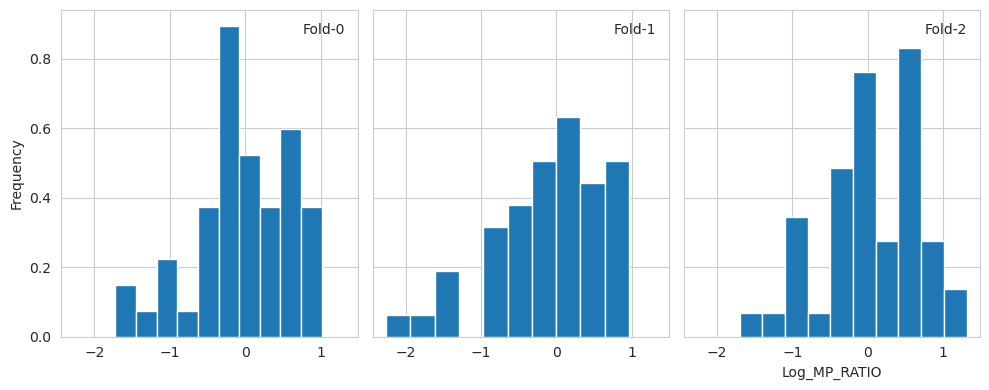

=====  Ridge  ===== 
	R2			:	 0.997165765153567 
	CV			:	 -4.531671086422144 
	Custom CV	:	 -3.182885699497317 
	R2			:	 -0.9724305531945325


In [52]:
test_utils = utils.Utils(full_train)
test_utils.create_cv_folds(display=True)
test_utils.display_score(Ridge(), X_full_train, y_full_train, X_full_test, y_full_test)

In [14]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-10, 1e10, log=True)

    solver = trial.suggest_categorical('solver', ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"])

    clf = Ridge(max_iter=100000, alpha=alpha, solver=solver)

    # n_ft = trial.suggest_int('n_ft', 1, 10, log=True)
    # clf = RFE(Ridge(max_iter=100000, alpha=alpha, solver=solver), n_features_to_select=n_ft)

    estimator = utils.Utils(full_train)
    # return cross_val_score(clf, X_full_train, y_full_train, cv=5, n_jobs=-1).mean()
    return estimator.cross_value_score(clf)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)
trial = study.best_trial
print(trial.value, trial.params)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.3918e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=8.13846e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.2706e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


0.3480097339811403 {'alpha': 117191.74850379501, 'solver': 'lsqr'}


In [6]:
test_utils.display_score(Ridge(**{'alpha': 117191.74850379501, 'solver': 'lsqr'}), X_full_train, y_full_train, X_full_test, y_full_test)
# display(plot_optimization_history(study))

rr = Ridge(**{'alpha': 117191.74850379501, 'solver': 'lsqr'}).fit(X_full_train, y_full_train)
y_full_train_pred = rr.predict(X_full_train)
y_full_test_pred = rr.predict(X_full_test)

test_utils.display_graph(rr, X_full_train, X_full_test, y_full_train, y_full_test)

=====  Ridge  ===== 
	R2			:	 0.6049703132912745 
	CV			:	 0.3097010826718615 
	Custom CV	:	 0.3480097339811403 
	R2			:	 0.04251980087752627


AttributeError: 'Utils' object has no attribute 'display_graph'

Fitting 3 folds for each of 477 candidates, totalling 1431 fits
[CV] END .............................n_features_to_select=2; total time=   1.5s
[CV] END .............................n_features_to_select=6; total time=   1.4s
[CV] END .............................n_features_to_select=8; total time=   1.5s
[CV] END ............................n_features_to_select=10; total time=   1.5s
[CV] END ............................n_features_to_select=11; total time=   1.5s
[CV] END ............................n_features_to_select=14; total time=   1.4s
[CV] END ............................n_features_to_select=17; total time=   1.3s
[CV] END ............................n_features_to_select=20; total time=   1.3s
[CV] END ............................n_features_to_select=22; total time=   1.2s
[CV] END ............................n_features_to_select=25; total time=   1.3s
[CV] END ............................n_features_to_select=28; total time=   1.2s
[CV] END ............................n_featur

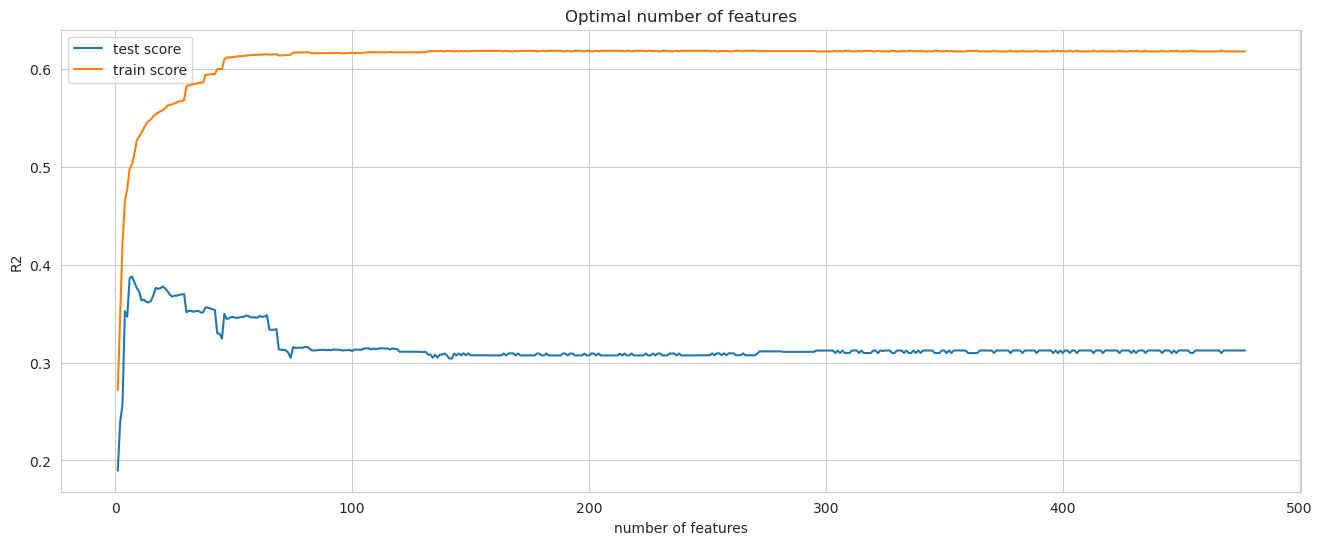

=====  RFE  ===== 
	R2			:	 0.5048290907110505 
	CV			:	 0.3880074665295033 
	Custom CV	:	 0.43374528541276 
	R2			:	 -0.005959708593913149


In [53]:
rr = Ridge(max_iter=100000, **({'alpha': 117191.74850379501, 'solver': 'lsqr'}))
rr.fit(X_full_train, y_full_train)


hyper_params = [{"n_features_to_select": list(range(1,len(X_full_train.columns)))}]

rfe = RFE(rr, step=1)

model_cv = GridSearchCV(estimator=rfe,
                        param_grid=hyper_params,
                        scoring="r2",
                        cv=3,
                        verbose=2,
                        return_train_score=True,
                        n_jobs=-1)


model_cv.fit(X_full_train, y_full_train)

cv_results = pd.DataFrame(model_cv.cv_results_)

best_rfe = model_cv.best_estimator_


plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel("number of features")
plt.ylabel("R2")
plt.title("Optimal number of features")
plt.legend(["test score", "train score"], loc="upper left")
plt.show()


test_utils.display_score(best_rfe,
                         X_full_train, y_full_train,
                         X_full_test, y_full_test)

In [7]:

# display(plot_optimization_history(study))

rr = Ridge(**{'alpha': 117191.74850379501, 'solver': 'lsqr'}).fit(X_full_train, y_full_train)
y_full_train_pred = rr.predict(X_full_train)
y_full_test_pred = rr.predict(X_full_test)

test_utils.display_graph(rr, X_full_train, X_full_test, y_full_train, y_full_test)

AttributeError: 'Utils' object has no attribute 'display_graph'

# Ionizable

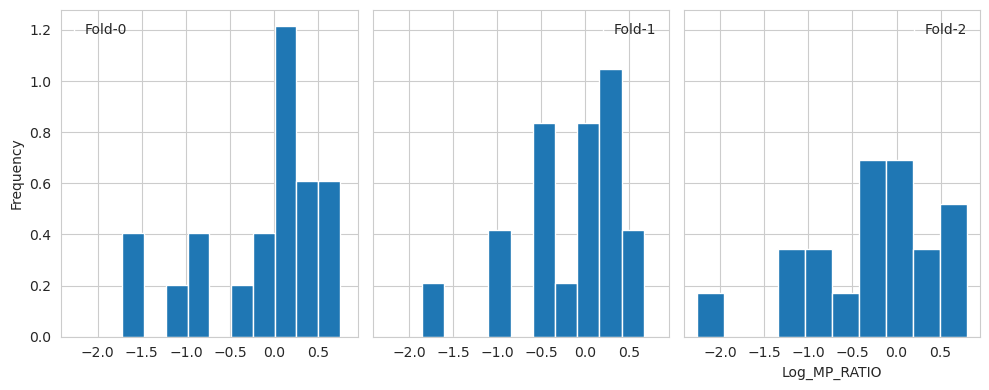

=====  Ridge  ===== 
	R2			:	 0.9999969224235767 
	CV			:	 -17.876277753019494 
	Custom CV	:	 -3.5859554783896583 
	R2			:	 -5.3084950570485105


In [47]:
test_utils = utils.Utils(ionizable_train)
test_utils.create_cv_folds(display=True)
test_utils.display_score(Ridge(), X_ionizable_train, y_ionizable_train, X_ionizable_test, y_ionizable_test)

In [9]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-10, 1e10, log=True)

    solver = trial.suggest_categorical('solver', ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"])

    clf = Ridge(max_iter=100000, alpha=alpha, solver=solver)

    # n_ft = trial.suggest_int('n_ft', 1, 10, log=True)
    # clf = RFE(Ridge(max_iter=100000, alpha=alpha, solver=solver), n_features_to_select=n_ft)

    estimator = utils.Utils(ionizable_train)
    # return cross_val_score(clf, X_ionizable_train, y_ionizable_train, cv=5, n_jobs=-1).mean()
    return estimator.cross_value_score(clf)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)
trial = study.best_trial
print(trial.value, trial.params)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.96945e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=6.21425e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.69844e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.56196e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", ove

0.06737814031286977 {'alpha': 23051583.217470333, 'solver': 'sparse_cg'}


Fitting 3 folds for each of 477 candidates, totalling 1431 fits
[CV] END ...........................n_features_to_select=260; total time=   0.4s
[CV] END ...........................n_features_to_select=262; total time=   0.5s
[CV] END ...........................n_features_to_select=266; total time=   0.4s
[CV] END ...........................n_features_to_select=268; total time=   0.4s
[CV] END ...........................n_features_to_select=271; total time=   0.4s
[CV] END ...........................n_features_to_select=273; total time=   0.4s
[CV] END ...........................n_features_to_select=276; total time=   0.4s
[CV] END ...........................n_features_to_select=278; total time=   0.4s
[CV] END ...........................n_features_to_select=281; total time=   0.4s
[CV] END ...........................n_features_to_select=284; total time=   0.4s
[CV] END ...........................n_features_to_select=287; total time=   0.4s
[CV] END ...........................n_feature

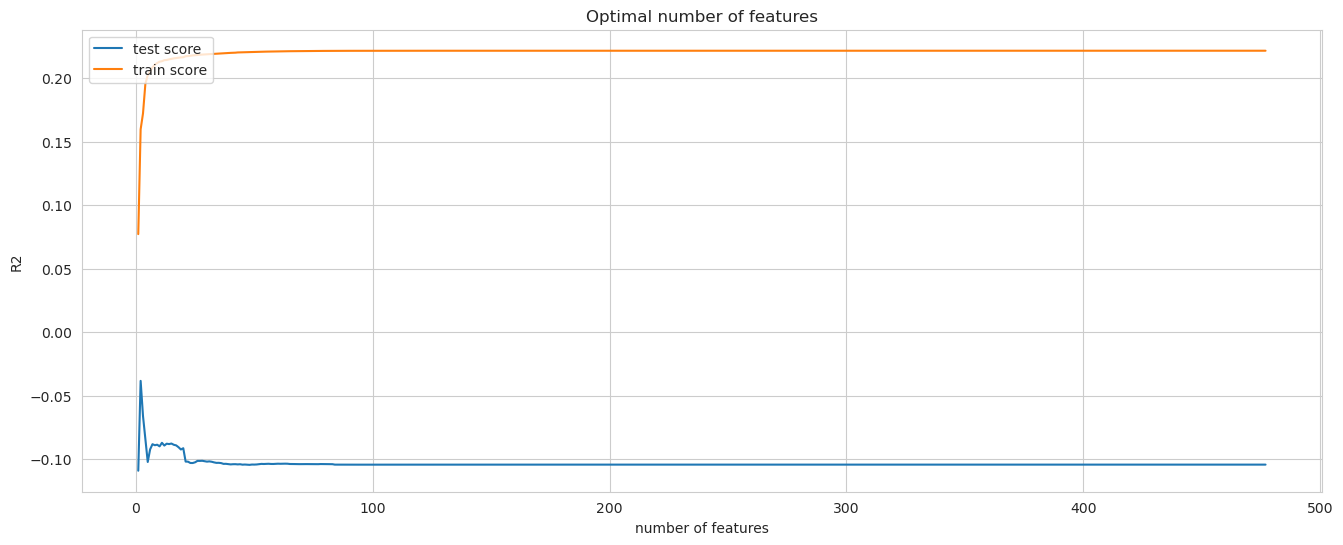

=====  RFE  ===== 
	R2			:	 0.17390337936038502 
	CV			:	 -0.03835931820365912 
	Custom CV	:	 0.0596999735647229 
	R2			:	 0.12713697133550284


In [51]:
rr = Ridge(max_iter=100000, **({'alpha': 23051583.217470333, 'solver': 'sparse_cg'}))
rr.fit(X_ionizable_train, y_ionizable_train)


hyper_params = [{"n_features_to_select": list(range(1,len(X_ionizable_train.columns)))}]

rfe = RFE(rr, step=1)

model_cv = GridSearchCV(estimator=rfe,
                        param_grid=hyper_params,
                        scoring="r2",
                        cv=3,
                        verbose=2,
                        return_train_score=True,
                        n_jobs=-1)


model_cv.fit(X_ionizable_train, y_ionizable_train)

cv_results = pd.DataFrame(model_cv.cv_results_)

best_rfe = model_cv.best_estimator_


plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel("number of features")
plt.ylabel("R2")
plt.title("Optimal number of features")
plt.legend(["test score", "train score"], loc="upper left")
plt.show()


test_utils.display_score(best_rfe,
                         X_ionizable_train, y_ionizable_train,
                         X_ionizable_test, y_ionizable_test)

In [12]:

# display(plot_optimization_history(study))

rr = Ridge(**{'alpha': 117191.74850379501, 'solver': 'lsqr'}).fit(X_ionizable_train, y_ionizable_train)
y_ionizable_train_pred = rr.predict(X_ionizable_train)
y_ionizable_test_pred = rr.predict(X_ionizable_test)

test_utils.display_graph(rr, X_ionizable_train, X_ionizable_test, y_ionizable_train, y_ionizable_test)

AttributeError: 'Utils' object has no attribute 'display_graph'

# Neutral

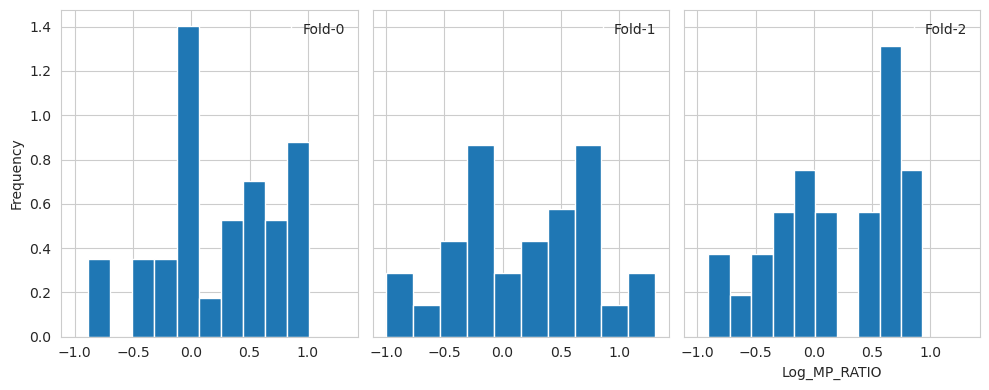

=====  Ridge  ===== 
	R2			:	 0.9991287541552191 
	CV			:	 -22.29400949553292 
	Custom CV	:	 -11.405703306889585 
	R2			:	 -9.84019682727549


In [55]:


test_utils = utils.Utils(neutral_train)
test_utils.create_cv_folds(display=True)
test_utils.display_score(Ridge(), X_neutral_train, y_neutral_train, X_neutral_test, y_neutral_test)

In [14]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-10, 1e10, log=True)

    solver = trial.suggest_categorical('solver', ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"])

    clf = Ridge(max_iter=100000, alpha=alpha, solver=solver)

    # n_ft = trial.suggest_int('n_ft', 1, 10, log=True)
    # clf = RFE(Ridge(max_iter=100000, alpha=alpha, solver=solver), n_features_to_select=n_ft)

    estimator = utils.Utils(neutral_train)
    # return cross_val_score(clf, X_neutral_train, y_neutral_train, cv=5, n_jobs=-1).mean()
    return estimator.cross_value_score(clf)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=-1, show_progress_bar=True)
trial = study.best_trial
print(trial.value, trial.params)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning:

Ill-conditioned matrix (rcond=1.33702e-18): result may not be accurate.

/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning:

Ill-conditioned matrix (rcond=1.57238e-18): result may not be accurate.

/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning:

Ill-conditioned matrix (rcond=3.61943e-18): result may not be accurate.

/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning:

Ill-conditioned matrix (rcond=1.59029e-17): result may not be accurate.

/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning:

Ill-conditioned matrix (rcond=2.78903e-18): result may not be accurate.

/home/penpen/mambaforge/envs/QSAR/lib/python3.11/site-packag

0.3698115932215174 {'alpha': 19553992.061135184, 'solver': 'lsqr'}


Fitting 3 folds for each of 477 candidates, totalling 1431 fits
[CV] END .............................n_features_to_select=2; total time=   0.8s
[CV] END .............................n_features_to_select=5; total time=   0.8s
[CV] END .............................n_features_to_select=8; total time=   0.7s
[CV] END ............................n_features_to_select=10; total time=   0.7s
[CV] END ............................n_features_to_select=12; total time=   0.7s
[CV] END ............................n_features_to_select=14; total time=   0.7s
[CV] END ............................n_features_to_select=17; total time=   0.8s
[CV] END ............................n_features_to_select=20; total time=   0.7s
[CV] END ............................n_features_to_select=22; total time=   0.7s
[CV] END ............................n_features_to_select=25; total time=   0.7s
[CV] END ............................n_features_to_select=27; total time=   0.7s
[CV] END ............................n_featur

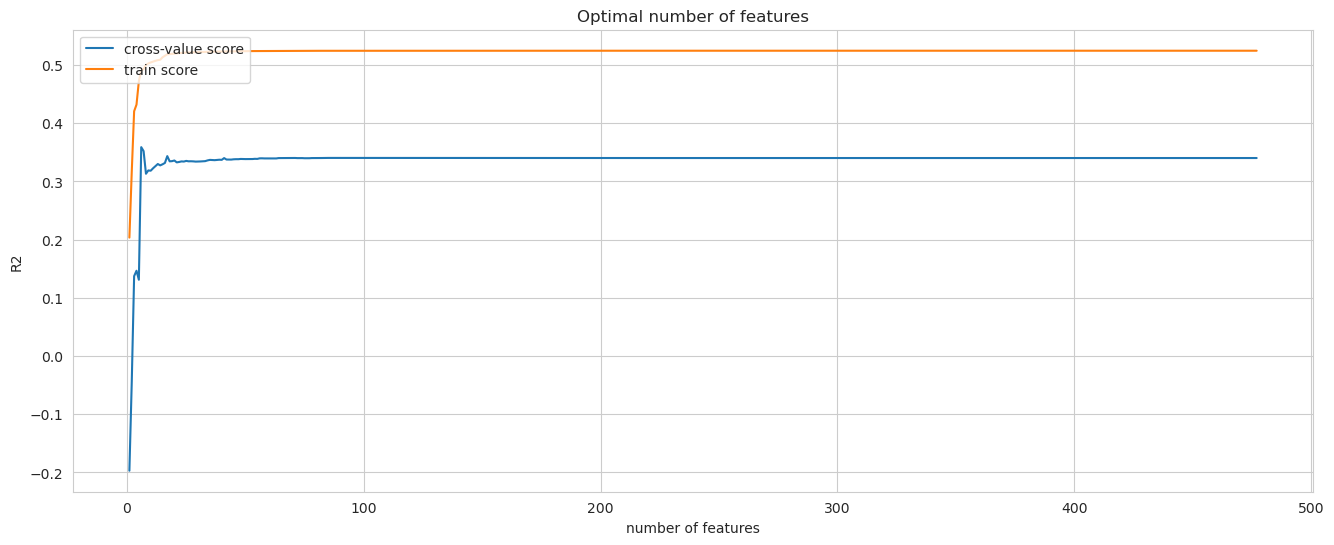

=====  RFE  ===== 
	R2			:	 0.5169320293388451 
	CV			:	 0.35899288964771187 
	Custom CV	:	 0.32460238467288116 
	R2			:	 0.13372969872047347


In [56]:
rr = Ridge(max_iter=100000, **({'alpha': 19553992.061135184, 'solver': 'lsqr'}))
rr.fit(X_neutral_train, y_neutral_train)


hyper_params = [{"n_features_to_select": list(range(1,len(X_neutral_train.columns)))}]

rfe = RFE(rr, step=1)

model_cv = GridSearchCV(estimator=rfe,
                        param_grid=hyper_params,
                        scoring="r2",
                        cv=3,
                        verbose=2,
                        return_train_score=True,
                        n_jobs=-1)


model_cv.fit(X_neutral_train, y_neutral_train)

cv_results = pd.DataFrame(model_cv.cv_results_)

best_rfe = model_cv.best_estimator_


plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel("number of features")
plt.ylabel("R2")
plt.title("Optimal number of features")
plt.legend(["cross-value score", "train score"], loc="upper left")
plt.show()


test_utils.display_score(best_rfe,
                         X_neutral_train, y_neutral_train,
                         X_neutral_test, y_neutral_test)

In [26]:

# display(plot_optimization_history(study))

rr = Ridge(**{'alpha': 117191.74850379501, 'solver': 'lsqr'}).fit(X_full_train, y_full_train)
y_full_train_pred = rr.predict(X_full_train)
y_full_test_pred = rr.predict(X_full_test)

test_utils.display_graph(rr, X_full_train, X_full_test, y_full_train, y_full_test)

AttributeError: 'Utils' object has no attribute 'display_graph'

# Demo of good R2 Q2 but bad cross val

In [ ]:
from sklearn.model_selection import LeaveOneOut, ShuffleSplit, StratifiedShuffleSplit

# THIS IS AN EXEMPLE OF A "GOOD" R2 and Q2 but it won't be found because the cross val is low



rr = Ridge()
rr.fit(X_full_train, y_full_train)

rfe = RFE(rr, n_features_to_select=20)
rfe = rfe.fit(X_full_train, y_full_train)


print(rfe.score(X_full_train, y_full_train))
print(rfe.score(X_full_test, y_full_test))
print(cross_val_score(rfe, X_full_train, y_full_train, scoring="r2", cv=ShuffleSplit(n_splits=4,test_size=0.1,random_state=0)).mean())
